In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import Matrix, Array
from sympy.abc import x, y, z
import torch
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import cProfile
import pstats

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
# Implementing SHAKE and RATTLE

In [4]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''

    def G_gs(tensor):
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(tensor) for g in gs], 0)

    return G_gs

In [5]:
def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), x)

In [6]:
def shake_step(x, v1, h, M, gs, e):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    #print(f"x = {x}, v1 = {v1}")
    G1 = G(gs)

    DV = np.zeros_like(x)
    DV[-1] = 10  # gravity acts in the last dimension
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    x2 = x_col + h * v1_col - h ** 2 * torch.inverse(M) @ DV_col

    Q_col = x2
    Q = torch.squeeze(Q_col)
    Dg_Q = J(gs, Q)
    Dg_q = J(gs, x)
    t = Dg_q[0, :].reshape(-1, 1)

    while torch.all(torch.abs(G1(Q)) > e):
        for i in range(len(gs)):
            t = Dg_q[i, :].reshape(-1, 1)
            Dg_Q = J(gs, Q)
            dL = gs[i](Q) / (Dg_Q[i, :] @ torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1))
            edit = (torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1)) * dL
            Q = torch.squeeze(Q_col - (torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1) * dL))
            Q_col = Q.reshape(-1, 1)
    v2 = (Q_col - x_col) / h
    return Q, v2

In [7]:
def shake_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    x = x_init
    v1 = v_init
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    for i in range(its):
        x, v1 = shake_step(x, v1, h, M, gs, 10 ** (-8))
        last_x = xs[-1]
        xs.append(x)
        last_v = vs[-1]
        vs.append(v1)
        v_n1 = 1/2 * (torch.squeeze(last_v) + torch.squeeze(v1))
        energy = 1/2 * torch.dot(torch.squeeze(v_n1),torch.squeeze(v_n1)) + torch.dot(torch.squeeze(last_x), -F)
        energies.append(energy)
    return xs, vs, energies

In [8]:
x_init = torch.tensor([1., 0.])  # a point which is on the curve
v_init = torch.tensor([0., 0.])  # starting with velocity zero
h = 0.1
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
its = 100
#x = shake_step(x_init, v_init , h, M, gs, 10**(-4))
positions_shake, vs_shake, energies_shake = shake_simulator(x_init, v_init, h, M, gs, 100)

In [9]:
def rattle_step(x, v1, h, M, gs, e , lamb):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    G1 = G(gs)


    DV = np.zeros_like(x)

    #DV[-1] = 10  # leaving this out for g-BAOAB
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    # doing Newton-Raphson iterations
    lam = lamb
    iters = 0
    x2 = x_col + h * v1_col - 0.5*(h**2)* torch.inverse(M) @ DV_col
    Q_col = x2
    Q = torch.squeeze(Q_col)
    J1 = J(gs, torch.squeeze(x_col))


    while iters <8:
        J2 = J(gs, torch.squeeze(Q))
        R = J2 @ torch.inverse(M) @ J1.t()
        dL = torch.inverse(R) @ G1(Q)
        #print(f"Q = {Q}")
        Q -= torch.inverse(M) @ J1.t() @ dL
        iters +=1

    #print(f"Updating v1_col, Jacobian {J(gs,torch.squeeze(x_col))}")
    #print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t()}")

    # half step for velocity
    Q_col = Q.reshape(-1,1)
    v1_half = (Q_col - x_col)/h
    x_col = Q_col
    J1 = J(gs, torch.squeeze(x_col))

    # getting the level
    J2 = J(gs, torch.squeeze(Q))
    P = J1 @ torch.inverse(M) @ J1.t()
    T = J1 @ (2/h * v1_half - torch.inverse(M) @ DV_col)

    #solving the linear system
    L = torch.linalg.solve(P,T)

    v1_col = v1_half - h/2 * DV_col - h/2 * J2.t()@L


    # print(f"Error = {G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))}")
    # # updating v
    # print(f"lam = {lam}")
    # print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t}")

    return torch.squeeze(x_col), torch.squeeze(v1_col)

In [10]:
def rattle_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    x = x_init
    v1 = v_init
    for i in range(its):
        x, v1 = rattle_step(x, v1, h, M, gs, 10 ** (-8), torch.zeros(len(gs)))
        energy = 1/2 * torch.dot(v1,v1) + torch.dot(x, -F)
        xs.append(x)
        vs.append(v1)
        energies.append(energy)
    return xs, vs, energies

In [11]:
import torch

In [12]:
x = torch.transpose(torch.tensor([[0,1],[2,3]]),0,1)

In [2]:
def gBAOAB_step_exact(q_init,p_init,F, gs, h,M, gamma, k):
    #print(f"q = {q_init[0]}")
    #print(f"Force = {F(q_init)[0]}")
    # Computing diagonalization
    evalues, evectors = np.linalg.eig(M)
    # Ensuring square root matrix exists
    evalues =np.real(evalues)
    evectors = np.real(evectors)
    evalues = evalues*(1- np.isclose(evalues, np.zeros_like(evalues), atol = np.finfo(float).eps))
    #print(evalues)
    #assert (evalues >= 0).all()
    sqrt_M = evectors * np.sqrt(evalues) @ np.linalg.inv(evectors)

    # setting up variables
    R = torch.randn(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h))
    b2 = torch.sqrt(k*(1-a2**(2)))

    #print(sqrt_M)
    # doing the initial p-update
    J1 = J(gs, torch.squeeze(q))
    G = J1
    L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h/2 * L1 @ F(q)
    #print(f"p1 update = { (h/2 * L1 @ F(q))[0] }")
    #print(f"p1 = {p[0]}")
    #print(f"Force = {F(q)}")

    # doing the first RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))
    #print(f"q1 = {q[0]}")
    #print(f"p2 = {p[0]}")
    #print(f"q1 = {q}")

    # the second p-update - (O-step in BAOAB)
    J2 = J(gs, torch.squeeze(q))
    G = J2
    L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p = a2* p + b2* sqrt_M @L2 @ sqrt_M @ R
    #print(f"p3 = {p[0]}")

    # doing the second RATTLE step
    q, p = rattle_step(q, p, h/2, M, gs, 10**(-2) , torch.zeros(len(q)))
    #print(f"q1 = {q}")
    #print(f"q2 = {q[0]}")

    # the final p update
    J3 = J(gs, torch.squeeze(q))
    G = J3
    L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h/2 * L3 @ F(q)
    #print(f"F = {F(q)}")
    #print(f"p4 update : { (h/2 * L3 @ F(q))[0]}")
    #print(f"p4 : {p[0]}")
    return q,p

In [14]:
def gBAOAB_integrator(q_init,p_init,F, gs, h,M, gamma, k, steps):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

In [15]:
def gBAOAB_integrator_mass(q_init,p_init,F, gs, h,M, gamma, k, steps):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        m = M(q)
        q, p = gBAOAB_step_exact(q,p, F,gs, h,m, gamma, k)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

~# Normal Distribution

In [16]:
def potential_norm(x):
    return -torch.log((torch.tensor([2])* torch.pi)**(-2) * torch.exp(-1/2 * x[0]**2))

def force_norm(x):
    return torch.squeeze(jacobian(potential_norm, x),0)

x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 1000
positions_norm, velocities_norm = gBAOAB_integrator(x_init,v_init, force_norm,gs, h,M, 1, 1, 1000)

q = tensor([1.])
Force = tensor([1.])
p1 update = tensor([0.])
p1 = tensor([0.])
q1 = 1.0
p2 = 0.0
p3 = 0.0
q2 = 0.9999938853967834
p4 update : 9.553979897319996e-08
p4 : -0.0015654291775571308
q = 0.9999938853967834
Force = 0.9999938853967834
p1 update = 9.553979897319996e-08
p1 = -0.001565524717356104
q1 = 0.9999755386762001
p2 = -0.003131221389004503
p3 = -0.0038223679551570747
q2 = 0.9999365625789284
p4 update : 9.911153865570828e-07
p4 : -0.0061564585922522135
q = 0.9999365625789284
Force = 0.9999365625789283
p1 update = 9.911153865570828e-07
p1 = -0.00615744970763877
q1 = 0.9998793381401312
p2 = -0.008491939823357653
p3 = -0.009436557290469473
q2 = 0.9997943546456445
p4 update : 3.212217557596208e-06
p4 : -0.01232230701164126
q = 0.9997943546456445
Force = 0.9997943546456445
p1 update = 3.212217557596208e-06
p1 = -0.012325519229198856
q1 = 0.999686790346307
p2 = -0.015210786185073644
p3 = -0.01813793036216741
q2 = 0.9995290628463662
p4 update : 7.353195830504507e-06
p4 : -0.02224

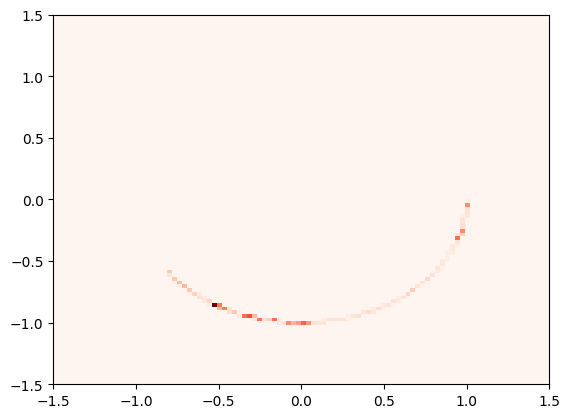

In [17]:
xs = [pos[0] for pos in positions_norm]
ys = [pos[1] for pos in positions_norm]

H, xedges, yedges, _ = plt.hist2d(xs,ys, bins = 100,range = [[-1.5, 1.5], [-1.5, 1.5]],cmap=plt.cm.Reds)

In [18]:
np.shape(H)

(100, 100)

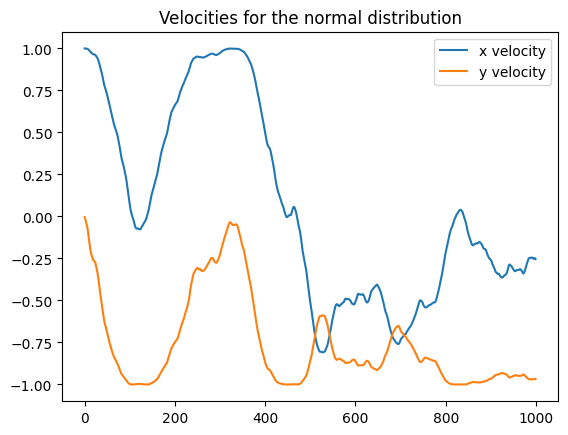

In [19]:
xs_norm = [v[0] for v in velocities_norm]
ys_norm = [v[1] for v in velocities_norm]
plt.plot(xs, label = 'x velocity')
plt.plot(ys, label = 'y velocity')
plt.title("Velocities for the normal distribution")
plt.legend()

Text(0.5, 1.0, 'Cumulative average potential for the Normal distribution')

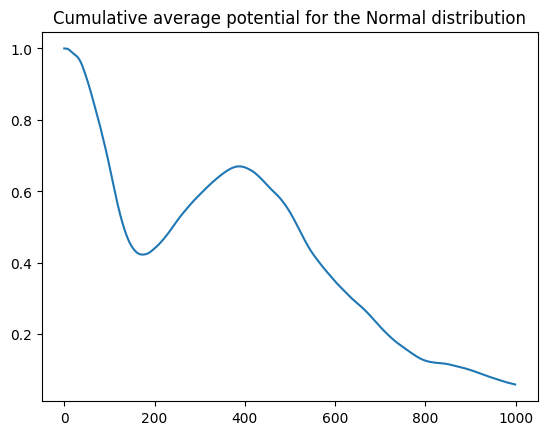

In [20]:
potentials_norm =  [potential_norm(pos).numpy() for pos in positions_norm]
potentials_norm = xs
avgs_norm=np.cumsum(potentials_norm)/range(1,len(potentials_norm)+1)
plt.plot(avgs_norm)
plt.title("Cumulative average potential for the Normal distribution")

# Bingham- Von Mises- Fisher Distribution

In [21]:
c = torch.tensor([1.,.5])
A = torch.tensor([[1.,2.],[2.,1.]])
def potential_BVMF(x):
    return -c@x - torch.squeeze(A@x)@x

def force_BVMF(x):
    return torch.squeeze(jacobian(potential_BVMF, x), dim = 0)

x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])

positions_BVMF, velocities_BVMF = gBAOAB_integrator(x_init,v_init, force_BVMF,gs, h,M, 1, 1, 1000)

q = tensor([1.])
Force = tensor([-3.])
p1 update = tensor([0.])
p1 = tensor([0.])
q1 = 0.9999999622814351
p2 = -9.655952453613281e-06
p3 = -6.556613591368036e-05
q2 = 0.9999977109463926
p4 update : 7.518567132700927e-05
p4 : -0.0005859608051234155
q = 0.9999977109463926
Force = -3.0085540217550117
p1 update = 7.518567132700927e-05
p1 = -0.0006611464764504247
q1 = 0.999989631940364
p2 = -0.0014070760536550797
p3 = -0.0017296854740507523
q2 = 0.9999717157028611
p4 update : 0.0002639462984598345
p4 : -0.0031208075275612787
q = 0.9999717157028611
Force = -3.0300280571873137
p1 update = 0.0002639462984598345
p1 = -0.0033847538260211134
q1 = 0.999939091807286
p2 = -0.004966937631569833
p3 = -0.008865114615514227
q2 = 0.9998501449853779
p4 update : 0.0006059312601194285
p4 : -0.014510978886445796
q = 0.9998501449853779
Force = -3.0689462368810263
p1 update = 0.0006059312601194285
p1 = -0.015116910146565224
q1 = 0.9997087767513634
p2 = -0.021072936671805556
p3 = -0.02621641500755472
q2 = 0.999

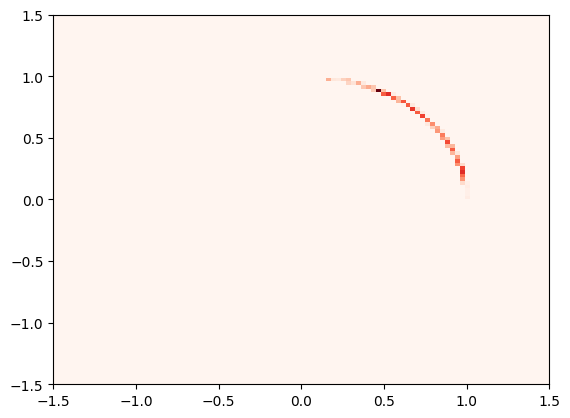

In [22]:
xs_BVMF = [pos[0] for pos in positions_BVMF]
ys_BVMF = [pos[1] for pos in positions_BVMF]

H, xedges, yedges, _ = plt.hist2d(xs_BVMF,ys_BVMF, bins = 100,range = [[-1.5, 1.5], [-1.5, 1.5]],cmap=plt.cm.Reds)

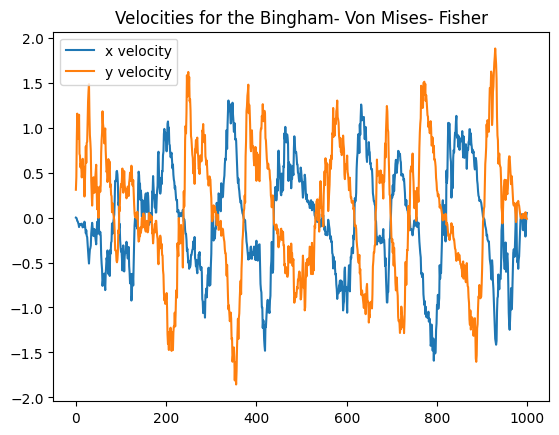

In [23]:
vxs_BVMF = [v[0] for v in velocities_BVMF]
vys_BVMF = [v[1] for v in velocities_BVMF]
plt.plot(vxs_BVMF, label = 'x velocity')
plt.plot(vys_BVMF, label = 'y velocity')
plt.title("Velocities for the Bingham- Von Mises- Fisher")
plt.legend()

Text(0.5, 1.0, 'Cumulative average potential for the Bingham- Von Mises- Distribution')

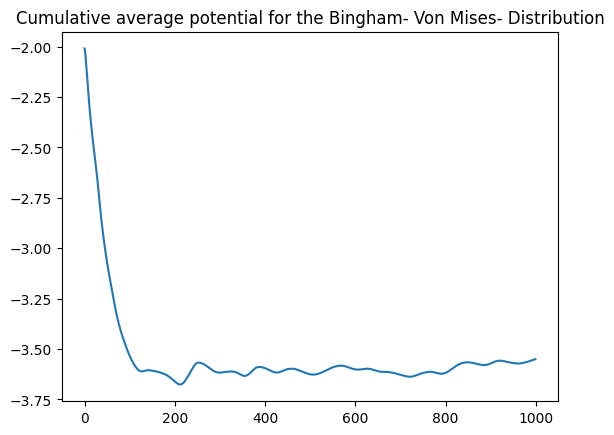

In [24]:
potentials_BVMF=  [potential_BVMF(pos).numpy() for pos in positions_BVMF]
avgs_BVMF=np.cumsum(potentials_BVMF)/range(1,len(potentials_BVMF)+1)
plt.plot(avgs_BVMF)
plt.title("Cumulative average potential for the Bingham- Von Mises- Distribution")

# Profiling

## CPU

In [25]:
import time

In [26]:
cProfile.run('gBAOAB_integrator(x_init,v_init, force_BVMF,gs, h,M, 1, 1, 1000)', 'cpu_gbaoab_1000')
p = pstats.Stats('cpu_gbaoab_10000')

q = tensor([1.])
Force = tensor([-3.])
p1 update = tensor([0.])
p1 = tensor([0.])
q1 = 0.9999998491257316
p2 = -3.8623809814453125e-05
p3 = -2.804343268693421e-05
q2 = 0.999999550499777
p4 update : 3.332653922039969e-05
p4 : -8.17313478524458e-05
q = 0.999999550499777
Force = -3.003791725935282
p1 update = 3.332653922039969e-05
p1 = -0.0001150578870728455
q1 = 0.9999982022205077
p2 = -0.00023010152831416525
p3 = 9.072135926925577e-05
q2 = 0.9999988411253432
p4 update : 5.350407372447256e-05
p4 : 1.9334199203546475e-05
q = 0.9999988411253432
Force = -3.006087342957748
p1 update = 5.350407372447256e-05
p1 = -3.4169874520926084e-05
q1 = 0.9999985587997917
p2 = -3.8105466144841316e-05
p3 = -7.478611154108015e-05
q2 = 0.9999979153175282
p4 update : 7.17524679658865e-05
p4 : -0.00016169781098139787
q = 0.9999979153175282
Force = -3.008163435520362
p1 update = 7.17524679658865e-05
p1 = -0.0002334502789472844
q1 = 0.9999956925830479
p2 = -0.00033556963452729434
p3 = 0.0006035546044812594
q2 = 

FileNotFoundError: [Errno 2] No such file or directory: 'cpu_gbaoab_10000'

In [ ]:
stats = p.sort_stats('tottime')
stats.print_stats()

# GPU

In [ ]:
torch.set_default_device('cpu')

In [ ]:
c = torch.tensor([1.,.5])
A = torch.tensor([[1.,2.],[2.,1.]])
def potential_BVMF(x):
    return -c@x - torch.squeeze(A@x)@x

def force_BVMF(x):
    return torch.squeeze(jacobian(potential_BVMF, x), dim = 0)

x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])

cProfile.run('gBAOAB_integrator(x_init,v_init, force_BVMF,gs, h,M, 1, 1, 1000)', 'gpu_gbaoab_1000')

In [ ]:
p1 = pstats.Stats('gpu_gbaoab_1000')
stats = p1.sort_stats('tottime')
stats.print_stats()

In [ ]:
def potential_1(x):
    # setting potential to (x^2 -1) + ...
    y = torch.squeeze(x**2)
    return torch.dot(y-1,y-1)

def force_1(x):
    return torch.squeeze(jacobian(potential_1, x), dim = 0)

x_init = torch.tensor([[1.],[0.], [0.]])
v_init = torch.tensor([[0.],[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1]**2 + x[2]** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])

gBAOAB_integrator(x_init,v_init, force_1,gs, h,M, 1, 1, 100)